In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

In [2]:
#load and read the training data
DRW_data_path = "/Users/garrettbrown/Desktop/CS189/DRW Competition/DRW_data/train.parquet"
data = pd.read_parquet(DRW_data_path)

#display the beginning of the data, and the shape
print(data.head())
n = data.shape[0]
d = data.shape[1] - 1
print(f"The total data set has {n} data points with {d} features, the last column is labels")

                     bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.181844   
2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.489497   
2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.260121   
2023-03-01 00:03:00    4.865   21.016  335.742   124.963  460.705  0.099976   
2023-03-01 00:04:00   27.158    3.451   98.411    44.407  142.818  0.270893   

                           X2        X3        X4        X5  ...      X772  \
2023-03-01 00:00:00 -0.637860  0.006652  0.136870  0.116698  ...  0.333753   
2023-03-01 00:01:00 -0.075619  0.431594  0.522400  0.475255  ...  0.333657   
2023-03-01 00:02:00 -0.444684  0.100695  0.224729  0.203282  ...  0.333667   
2023-03-01 00:03:00 -0.666728 -0.123858  0.019197  0.014459  ...  0.333174   
2023-03-01 00:04:00 -0.325973  0.116336  0.234311  0.214073  ...  0.333171   

                         X773      X774      X775      X

In [3]:
#let's get some basic information about the data set
description = data.describe()
print(description)

#i) from this we see that the proprietary data and labels is more or less normalized, and most of them lie in a small range
#however, the extreme values can be quite large in comparison. Maybe this can be used to identify some signal?

#ii) Note the volume is just the sum of the sell_qty and buy_qty so it adds no new information.

#iii) how do differences of the buy/sell quantities compare to the price movement?

             bid_qty        ask_qty        buy_qty       sell_qty  \
count  525886.000000  525886.000000  525886.000000  525886.000000   
mean        9.967948      10.174161     131.712690     132.660088   
std        15.645712      15.889598     307.184897     309.728730   
min         0.001000       0.001000       0.000000       0.000000   
25%         2.634000       2.678000      26.407000      27.020250   
50%         6.415000       6.538000      57.015000      58.044500   
75%        13.085000      13.330000     127.626000     129.100500   
max      1114.932000    1352.965000   17609.567000   17685.503000   

              volume             X1             X2             X3  \
count  525886.000000  525886.000000  525886.000000  525886.000000   
mean      264.372778      -0.033823      -0.000269      -0.000307   
std       588.457585       0.912125       0.937410       0.933608   
min         0.000000      -4.746617      -8.953153      -7.410052   
25%        60.687000      -0.6515

<Axes: xlabel='X732'>

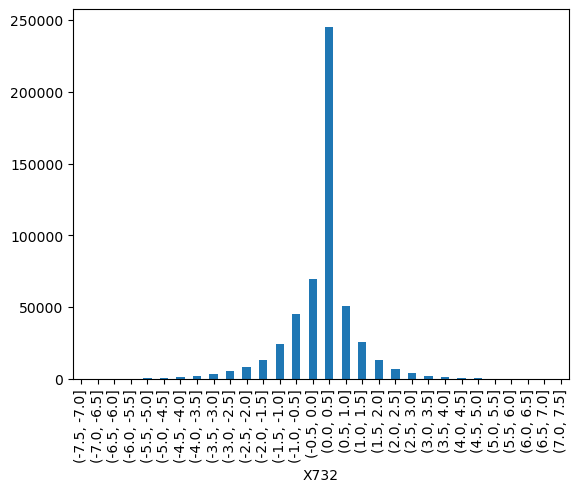

In [4]:
#here is a histogram of the data of an anonymized feature, most of them look like this
bins = [i / 2 for i in range(-15, 16)]
counts = pd.cut(data.loc[:, "X732"], bins).value_counts().sort_index()
counts.plot(kind='bar')

In [5]:
#Playing around reveals that some have a few values that appear a ton and the others unique

print(data.loc[:, "X732"].value_counts().sort_values(ascending = False))
print(data.loc[:, "X698"].value_counts().sort_values(ascending = False))

#in the second example we see some numbers that should be treated the same so we
data = data.round(6)

X732
 0.048860    168182
-0.838836         1
-0.852429         1
-1.006355         1
-1.100593         1
              ...  
-1.394349         1
 0.279670         1
-1.981144         1
-1.982869         1
-0.646135         1
Name: count, Length: 357705, dtype: int64
X698
-0.009412    30404
-0.009412     2423
-0.009412     1122
-0.009412      990
-0.009412      749
             ...  
 1.459555        1
 1.171139        1
-0.167012        1
 1.261102        1
-0.745065        1
Name: count, Length: 471232, dtype: int64


In [6]:
print(data.loc[:, "bid_qty"].value_counts().sort_values(ascending = False))

bid_qty
0.001     866
0.003     580
0.002     439
0.008     247
0.004     236
         ... 
39.540      1
41.182      1
59.777      1
43.548      1
44.275      1
Name: count, Length: 45801, dtype: int64


Text(0.5, 1.0, 'Most Frequent Value Count per Feature')

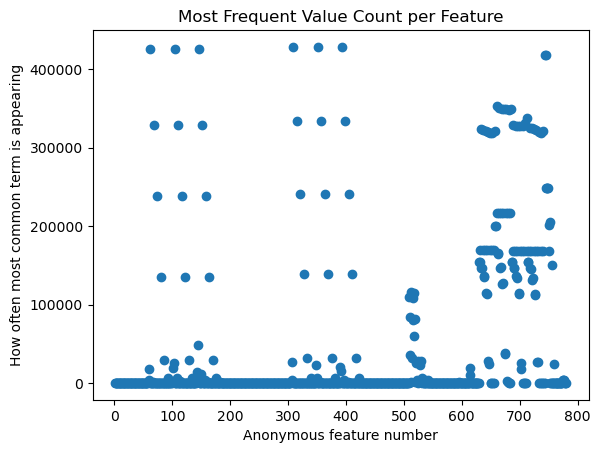

In [7]:
x = [i for i in range(1, 781)]
y = [data.loc[:, f"X{i}"].value_counts().max() for i in range(1, 781)]
plt.scatter(x, y)
plt.xlabel("Anonymous feature number")
plt.ylabel("How often most common term is appearing")
plt.title("Most Frequent Value Count per Feature")

In [8]:
#check for any other bunk values
print(data.isna().any().any())
print(np.isinf(data.values).any())

False
False


In [9]:
#ok great, so now let's throw out the features that have many repeating values for now
filtered_columns = [col for col in data.columns if data[col].value_counts().max() <= 2000]
data = data[filtered_columns]
print(data.head())
print(data.shape)

                     bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.181844   
2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.489497   
2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.260121   
2023-03-01 00:03:00    4.865   21.016  335.742   124.963  460.705  0.099976   
2023-03-01 00:04:00   27.158    3.451   98.411    44.407  142.818  0.270893   

                           X2        X3        X4        X5  ...      X768  \
2023-03-01 00:00:00 -0.637860  0.006652  0.136870  0.116698  ... -0.033984   
2023-03-01 00:01:00 -0.075619  0.431594  0.522400  0.475255  ... -0.030115   
2023-03-01 00:02:00 -0.444684  0.100695  0.224729  0.203282  ... -0.030757   
2023-03-01 00:03:00 -0.666728 -0.123858  0.019197  0.014459  ... -0.030052   
2023-03-01 00:04:00 -0.325973  0.116336  0.234311  0.214073  ... -0.031941   

                         X769      X770      X771      X

In [10]:
X = data.loc[:, "X1":"X780"]
y = data.loc[:, "label"]
y_array = np.array(y)
X_array = np.array(X)
corr_matrix = np.corrcoef(X_array, rowvar=False)

Text(0.5, 1.0, 'Feature Correlation Heatmap')

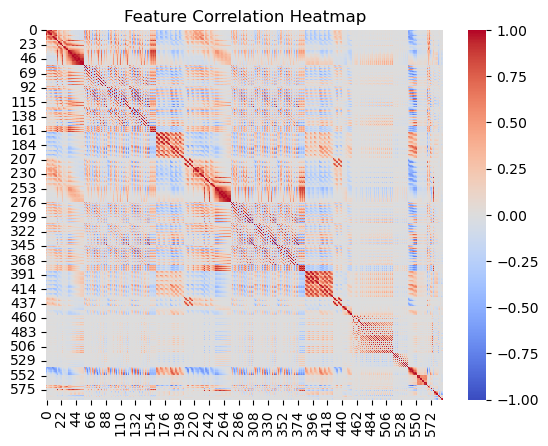

In [11]:
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")

In [12]:
np.fill_diagonal(corr_matrix, 0)
high_corr = np.where(np.abs(corr_matrix) > 0.9)
high_corr = [
    (i, j)
    for i, j in zip(*high_corr) if i < j
]

to_drop = set()
for pair in high_corr:
    if np.abs(np.corrcoef(X_array[:, pair[0]], y_array)[0, 1]) >= np.abs(np.corrcoef(X_array[:, pair[1]], y_array)[0, 1]):
        to_drop.add(pair[1])
    else:
        to_drop.add(pair[0])

In [13]:
to_drop = list(to_drop)
for i in range(len(to_drop)):
    to_drop[i] += 5

col_names_to_drop = data.columns[to_drop]
data = data.drop(columns=col_names_to_drop)

Text(0.5, 1.0, 'Feature Correlation Heatmap')

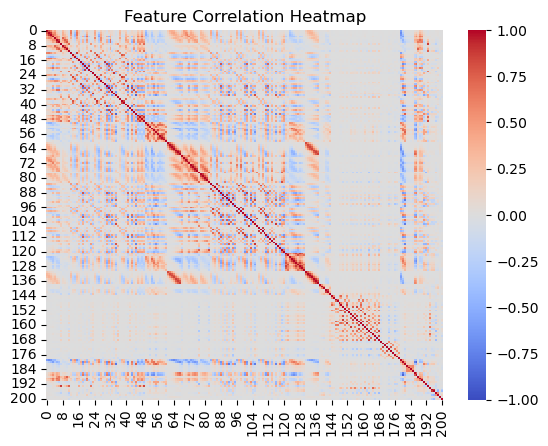

In [14]:
X = data.loc[:, "X2":"X780"]
X_array = np.array(X)
corr_matrix = np.corrcoef(X_array, rowvar=False)

sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")

In [15]:
#Now we get rid of the volume since its buy_qty + sell_qty
data = data.drop(columns = "volume")

In [16]:
#Now we want to preprocess the data a bit to apply Lasso for feature selection
#We need to normalize the non-anonymized columns
lasso_data = data
lasso_data.loc[:, "bid_qty":"sell_qty"] = (lasso_data.loc[:, "bid_qty":"sell_qty"] 
                                           - data.loc[:, "bid_qty":"sell_qty"].mean()) / (data.loc[:, "bid_qty":"sell_qty"].std())

In [17]:
test_lasso_data = lasso_data.iloc[:, :]

# Split features and target
X = test_lasso_data.iloc[:, :-1]
y = test_lasso_data.iloc[:, -1]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit LassoCV with high iteration limit
lasso = LassoCV(cv=5, max_iter=10000, n_alphas=30, random_state=42, n_jobs=-1)
lasso.fit(X_scaled, y)

LassoCV(cv=5, max_iter=10000, n_alphas=30, n_jobs=-1, random_state=42)

In [18]:
#now drop all the features where lasso is equal to zero
to_drop = data.iloc[:, :-1].columns[lasso.coef_ == 0]
new_data = data.drop(columns = to_drop)
new_data

[-0.         -0.          0.          0.         -0.          0.
  0.          0.         -0.          0.          0.0294078   0.
  0.          0.          0.00851854  0.          0.          0.
  0.          0.          0.          0.          0.         -0.00396439
  0.          0.          0.         -0.          0.          0.
  0.          0.          0.         -0.          0.         -0.
  0.          0.          0.          0.         -0.         -0.
  0.          0.          0.          0.         -0.          0.
  0.          0.          0.00653305  0.          0.          0.
  0.         -0.          0.          0.         -0.          0.
  0.01492176  0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.02882985  0.         -0.
 -0.          0. 

,X21,X28,X77,X181,X219,X287,X465,X508,X757,X758,label
2023-03-01 00:00:00,1.122363,1.625849,0.281357,-0.931880,-0.654146,0.073799,0.234483,0.289762,-0.704807,-0.730939,0.562539
2023-03-01 00:01:00,0.927885,1.395087,0.276344,-0.937555,-0.634723,0.054294,0.241404,0.289762,-0.673748,-0.725971,0.533686
2023-03-01 00:02:00,0.839011,1.259501,0.271414,-0.939028,-0.631882,0.054242,0.242712,0.280925,-0.669792,-0.725973,0.546505
2023-03-01 00:03:00,0.850572,1.434907,0.266566,-0.940241,-0.612901,0.042534,0.243212,0.268853,-0.665870,-0.725976,0.357703
2023-03-01 00:04:00,0.856979,1.438707,0.261798,-0.939632,-0.607648,0.044647,0.246073,0.255648,-0.662004,-0.725978,0.362452
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 23:55:00,1.062147,0.229225,-0.060528,-0.027716,0.195489,-1.519859,0.690841,-2.226884,-0.724258,0.441170,0.396289
2024-02-29 23:56:00,1.124881,0.327540,-0.059890,-0.027370,0.200395,-1.514848,0.693993,-2.221530,-0.495847,0.459453,0.328993
2024-02-29 23:57:00,0.263199,0.114234,-0.059262,-0.027025,0.204908,-1.515772,0.704330,-2.218139,-0.496481,0.459448,0.189909
2024-02-29 23:58:00,1.092234,0.321094,-0.058644,-0.026680,0.201596,-1.495308,0.696660,-2.209197,-0.497092,0.459443,0.410831


Text(0.5, 1.0, 'Feature Correlation Heatmap')

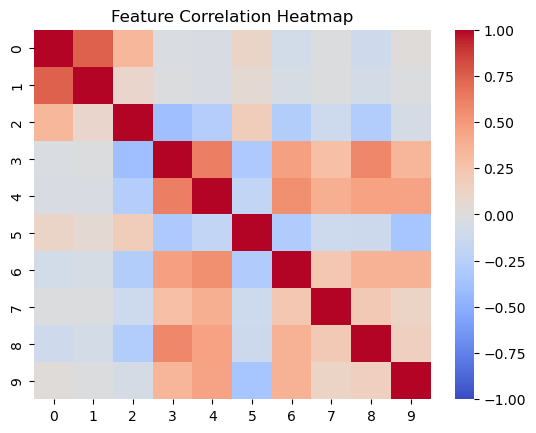

In [40]:
#look at correlations of our selected features
X = new_data.iloc[:, :-1]
X_array = np.array(X)
corr_matrix = np.corrcoef(X_array, rowvar=False)

sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")

,X21,X28,X77,X181,X219,X287,X465,X508,X757,X758,label
2023-03-01 00:00:00,1.122363,1.625849,0.281357,-0.931880,-0.654146,0.073799,0.234483,0.289762,-0.704807,-0.730939,0.562539
2023-03-01 00:01:00,0.927885,1.395087,0.276344,-0.937555,-0.634723,0.054294,0.241404,0.289762,-0.673748,-0.725971,0.533686
2023-03-01 00:02:00,0.839011,1.259501,0.271414,-0.939028,-0.631882,0.054242,0.242712,0.280925,-0.669792,-0.725973,0.546505
2023-03-01 00:03:00,0.850572,1.434907,0.266566,-0.940241,-0.612901,0.042534,0.243212,0.268853,-0.665870,-0.725976,0.357703
2023-03-01 00:04:00,0.856979,1.438707,0.261798,-0.939632,-0.607648,0.044647,0.246073,0.255648,-0.662004,-0.725978,0.362452
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 23:55:00,1.062147,0.229225,-0.060528,-0.027716,0.195489,-1.519859,0.690841,-2.226884,-0.724258,0.441170,0.396289
2024-02-29 23:56:00,1.124881,0.327540,-0.059890,-0.027370,0.200395,-1.514848,0.693993,-2.221530,-0.495847,0.459453,0.328993
2024-02-29 23:57:00,0.263199,0.114234,-0.059262,-0.027025,0.204908,-1.515772,0.704330,-2.218139,-0.496481,0.459448,0.189909
2024-02-29 23:58:00,1.092234,0.321094,-0.058644,-0.026680,0.201596,-1.495308,0.696660,-2.209197,-0.497092,0.459443,0.410831
